In [35]:
import networkx as nx
import math
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm

In [36]:
data = sio.loadmat('Data.mat')['D']
print(data.shape)
df = pd.DataFrame(data)
df.head()

(10000, 8)


,0,1,2,3,4,5,6,7
0,0.110542,1.042710,-1.575183,1.055074,-0.148899,1.062382,0.116945,-0.244467
1,1.397050,0.257278,-0.351936,-0.232494,1.344092,-0.060821,0.387983,1.618541
2,0.690281,1.321500,1.417502,0.982115,-0.716820,-0.508841,-1.768362,2.926619
3,-0.634045,-1.255488,-0.578344,-0.305612,0.273759,0.533964,-1.647791,-0.963040
4,-0.376387,0.863437,-0.296768,0.625518,-0.577722,0.855256,2.067983,-0.582378


In [37]:
G = nx.Graph()
vertex_set = [i for i in range(df.shape[1])]

In [38]:
for v in vertex_set:
    G.add_node(v)

# Implementation of PC pop Algorithm

In [39]:
def nodes_connected(u, v):
    return u in G.neighbors(v)

In [40]:
def compute_pairs():
    adj_vertices = []
    for i in range(len(vertex_set)):
        for j in range(i+1, len(vertex_set)):
            if nodes_connected(vertex_set[i], vertex_set[j]):
                adj_vertices.append((vertex_set[i], vertex_set[j]))
    return adj_vertices

In [41]:
def remove_in_adj(x, y):
    result = set()
    for i in G.adj[x]:
        if i != y:
            result.add(i)
    return result

In [42]:
def compute_subsets(set_, k):
    return list(itertools.combinations(set_, k))

In [43]:
def finished(d):
    all_done = True
    for (x, y) in compute_pairs():
        new_adj_set = remove_in_adj(x, y)
        if len(new_adj_set) >= d:
            all_done = False
    return all_done

In [44]:
df.values.shape[0]

10000

In [45]:
# Conditional independence test
def gaussCItest(suffStat, x, y, S):
    C = suffStat["C"]
    n = suffStat["n"]

    cut_at = 0.9999999

    # bias coefficient (math.)
    # There's no nodes in S.
    if len(S) == 0:
        r = C[x, y]

    # There's only one node in S, the first-order bias correlation coefficient.
    elif len(S) == 1:
        r = (C[x, y] - C[x, S] * C[y, S]) / math.sqrt((1 - math.pow(C[y, S], 2)) * (1 - math.pow(C[x, S], 2)))

    # I actually don't quite understand what's being begged here, 
    # but that's what the pcalg package for the R language says
    else:
        #print(x, y, list(S))
        m = C[np.ix_([x]+[y]+list(S), [x]+[y]+list(S))]
        PM = np.linalg.pinv(m)
        r = -1 * PM[0, 1] / math.sqrt(abs(PM[0, 0] * PM[1, 1]))

    r = min(cut_at, max(-1*cut_at, r))
    # Fisher’s z-transform
    res = math.sqrt(n - len(S) - 3) * .5 * math.log1p((2 * r) / (1 - r))
    # Φ^{-1}(1-α/2)
    return 2 * (1 - norm.cdf(abs(res)))

In [46]:
def pc_pop_algo(vertex_set, df, alpha):
    #First step: Construct the complete undirected graph on the vertex set V
    for i in range(len(vertex_set)):
        for j in range(i+1, len(vertex_set)):
            G.add_edge(vertex_set[i], vertex_set[j])
            
    nx.draw(G, with_labels = True)
    
    #Second step: Perform conditional independence tests at a given significance level α 
    #and delete edges based on the tests.
    d = 0
    all_done = False
    
    # Sufficient Statistic
    n = df.values.shape[0]
    C = df.corr().values
    suffStat={"C": C, "n": n}
    
    while not finished(d):
        for (x, y) in compute_pairs():
            new_adj_set = remove_in_adj(x, y)
            print('x: ',x, ', y: ',y)
            #print(new_adj_set)
            #print(d)
            if len(new_adj_set) >= d:
                for z in compute_subsets(new_adj_set, d):
                    print('z: ',z)
                    #Test conditional independance I(x, y | z) and remove edge
                    pVal = gaussCItest(suffStat, x, y, z)
                    print('pVal: ', pVal)
                    # Threshold
                    threshold = norm.pdf(1 - alpha/2)**(-1) / math.sqrt(n - len(z) - 3)
                    print('threshold: ', threshold)
                    if pVal > threshold :
                        #print(G.node)
                        #print(x,y)
                        G.remove_edge(x,y)               
        d = d + 1
    return G               
    
    

# Try it

x:  0 , y:  1
z:  ()
pVal:  0.9826838813250092
threshold:  0.03321241157573187
x:  0 , y:  2
z:  ()
pVal:  0.0
threshold:  0.03321241157573187
x:  0 , y:  3
z:  ()
pVal:  0.0
threshold:  0.03321241157573187
x:  0 , y:  4
z:  ()
pVal:  0.0
threshold:  0.03321241157573187
x:  0 , y:  5
z:  ()
pVal:  0.0
threshold:  0.03321241157573187
x:  0 , y:  6
z:  ()
pVal:  0.0
threshold:  0.03321241157573187
x:  0 , y:  7
z:  ()
pVal:  0.0
threshold:  0.03321241157573187
x:  1 , y:  2
z:  ()
pVal:  0.883867913071704
threshold:  0.03321241157573187
x:  1 , y:  3
z:  ()
pVal:  0.18922731169707685
threshold:  0.03321241157573187
x:  1 , y:  4
z:  ()
pVal:  0.7087147147441566
threshold:  0.03321241157573187
x:  1 , y:  5
z:  ()
pVal:  0.8083358138482941
threshold:  0.03321241157573187
x:  1 , y:  6
z:  ()
pVal:  0.0
threshold:  0.03321241157573187
x:  1 , y:  7
z:  ()
pVal:  0.7713758457819528
threshold:  0.03321241157573187
x:  2 , y:  3
z:  ()
pVal:  0.0
threshold:  0.03321241157573187
x:  2 , y:  4


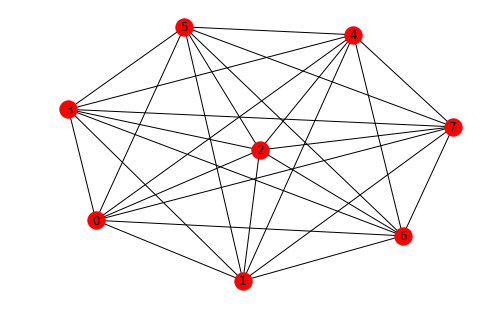

In [47]:
pc_pop_algo(vertex_set, df, 0.5)

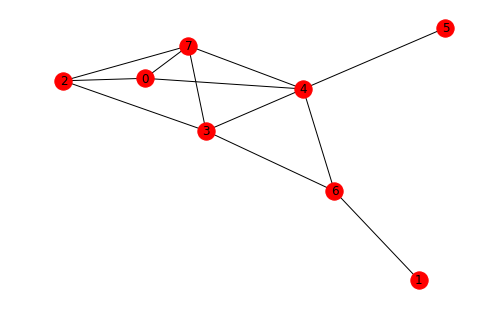

In [49]:
# Final G after PCalgorithm
nx.draw(G, with_labels = True)